# Event Segmentation Analysis

The following notebook contains the formal analysis procedure for the hidden markov modeling of continuous fMRI data.

# A note on the imports

A good portion of this analysis is built on `decker_honors_module`, an installable "package" created specifically to streamline Will Decker's honors thesis project. Usage and notes on this code are located in the GitHub repo [here](https://github.com/w-decker/decker_honors_module). Other important dependencies include [Brainiak](brainiak.org) and [Nilearn](https://nilearn.github.io/stable/index.html). Some `conda` environments have been created to certain portions of the code. `.yml` files will be included and named according to their dedicated use. 

# Importing data

`decker.utils.io.io` contains a class, `BIDSio` created to handle the project's data in BIDS format. There is also a conda environment dedicated to just this procedure.

You only need to **run once!**

In [ ]:
# !wget # add .yml
# !conda create -f bidsio.yml
!conda activate bidio

In [3]:
# import BIDSio
from decker.utils.io.io import BIDSio

Get the data to the environment by showing `BIDSio` where the BIDS root is.

In [4]:
bids_root = "/data/jdecke5/projects/honors-thesis/data/bids"
bids = BIDSio(bids_path=bids_root)

# bind bids_root to BIDSio
bids.init()

BIDSio(bids_path='/data/jdecke5/projects/honors-thesis/data/bids')

Display some information about the BIDS dataset.

In [5]:
bids.info()

Subjects: 
	 ['SL001', 'SL002', 'SL003', 'SL004', 'SL005', 'SL006', 'SL007', 'SL008', 'SL009', 'SL010', 'SL011', 'SL012', 'SL013', 'SL014', 'SL015', 'SL016', 'SL017', 'SL018', 'SL019']

Total subjects: 
	 19

Tasks: 
	 ['rest', 'statlearning']

Total tasks: 
	 2



Get list of functional data.

In [6]:
data = bids.get_func(task='statlearning', suffix="bold")
data

['/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL001/func/sub-SL001_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL002/func/sub-SL002_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL003/func/sub-SL003_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL004/func/sub-SL004_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL005/func/sub-SL005_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL006/func/sub-SL006_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projec

Because we need to jump between `conda environments` save, the list of files to a `.csv` or whatever file. 

In [8]:
import pandas as pd
out = "/data/jdecke5/projects/honors-thesis/data"
df = pd.DataFrame(data={"files": data}).to_csv(f"{out}/pps.csv")

Switch to `brainiak_env`!

Load back file list

In [3]:
import pandas as pd
out = "/data/jdecke5/projects/honors-thesis/data"
df = pd.read_csv(f'{out}/pps.csv')
data = list(df["files"])
data

['/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL001/func/sub-SL001_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL002/func/sub-SL002_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL003/func/sub-SL003_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL004/func/sub-SL004_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL005/func/sub-SL005_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL006/func/sub-SL006_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projec

We can ensure that we have to correct number of files by comparing output from `BIDSio.info()` and `BIDSio.ge_func()`.

# Importing participant database

`decker.utils.io.io` contains a function, `parse_pdb()`, which reads a file (either .xlsx or .csv) and transposes it based on a factor. So in this case, it transposes our data from wide to long by the conditions each participant belongs to.

In [6]:
from decker.utils.io.io import parse_pdb

In [7]:
db = "/data/jdecke5/projects/honors-thesis/data/participant_database.xlsx"
pps = parse_pdb(path=db, subid_col="Subject ID", cond_col="COND")

Let's see what this looks like.

In [8]:
pps

{'S': ['SL001',
  'SL003',
  'SL004',
  'SL007',
  'SL009',
  'SL011',
  'SL013',
  'SL015',
  'SL017',
  'SL019'],
 'R': ['SL002',
  'SL005',
  'SL006',
  'SL008',
  'SL010',
  'SL012',
  'SL014',
  'SL016',
  'SL018']}

You can see now that the subject IDs of each participant have been grouped by which condition they are in.

# Masking the data

This uses some functionality from `decker.analysis.utils.utils`.

In [1]:
# imports
from decker.analysis.utils.utils import nilearn_mask_single_data, nilearn_mask_group_by_condition

/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


Demonstrating on one subject

label value,region name,size (in mm^3),relative size (in %)
1,Frontal Pole,120948,11.47
2,Insular Cortex,21449,2.03
3,Superior Frontal Gyrus,45246,4.29
4,Middle Frontal Gyrus,45499,4.32
5,"Inferior Frontal Gyrus, pars triangularis",9503,0.9
6,"Inferior Frontal Gyrus, pars opercularis",11674,1.11
7,Precentral Gyrus,70031,6.64
8,Temporal Pole,37827,3.59
9,"Superior Temporal Gyrus, anterior division",4482,0.43
10,"Superior Temporal Gyrus, posterior division",6488,0.62


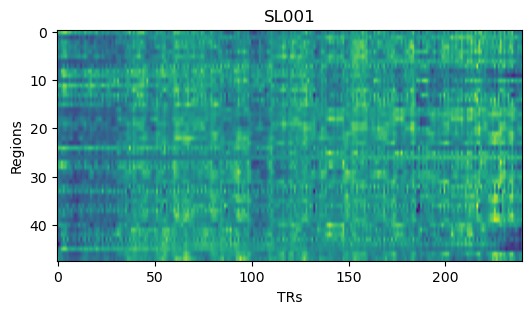

In [4]:
roidat, labels, report = nilearn_mask_single_data(atlas="cort-maxprob-thr25-1mm", file=data[0], report=True, plot=True)
report

Now let's do this for all subjects and parse the data by condition

In [9]:
roidata = nilearn_mask_group_by_condition(cond=pps, atlas="cort-maxprob-thr25-1mm", files=data)

Beginning masking procedure...
------------------------------

Masking: SL001 and adding to group: S 

Masking: SL003 and adding to group: S 

Masking: SL004 and adding to group: S 

Masking: SL007 and adding to group: S 

Masking: SL009 and adding to group: S 

Masking: SL011 and adding to group: S 

Masking: SL013 and adding to group: S 

Masking: SL015 and adding to group: S 

Masking: SL017 and adding to group: S 

Masking: SL019 and adding to group: S 

Masking: SL002 and adding to group: R 

Masking: SL005 and adding to group: R 

Masking: SL006 and adding to group: R 

Masking: SL008 and adding to group: R 

Masking: SL010 and adding to group: R 

Masking: SL012 and adding to group: R 

Masking: SL014 and adding to group: R 

Masking: SL016 and adding to group: R 

Masking: SL018 and adding to group: R 

------------------------------

Done!


Let's save this data so we can use it for later.

In [10]:
import numpy as np
import os

eventseg_dir = "/data/jdecke5/projects/honors-thesis/data/eventseg"
np.save(os.path.join(eventseg_dir, 'masked_data.npy'), roidata)

Let's read in the data

In [14]:
roidata_masked = np.load(os.path.join(eventseg_dir, 'masked_data.npy'), allow_pickle=True)[()]

Take a loot at `roidata`, a `dict` of `np.ndarray`s

In [15]:
# Do conditions match what we expected?
print(f'Conditions: {list(roidata_masked.keys())}\n')

# How many subjects in each condition? Is it what we expect?
[print(f'{i} : {len(roidata_masked[i])}') for i in roidata.keys()]

Conditions: ['S', 'R']

S : 10
R : 9


[None, None]

Text(0.5, 0.98, 'Subject SL008')

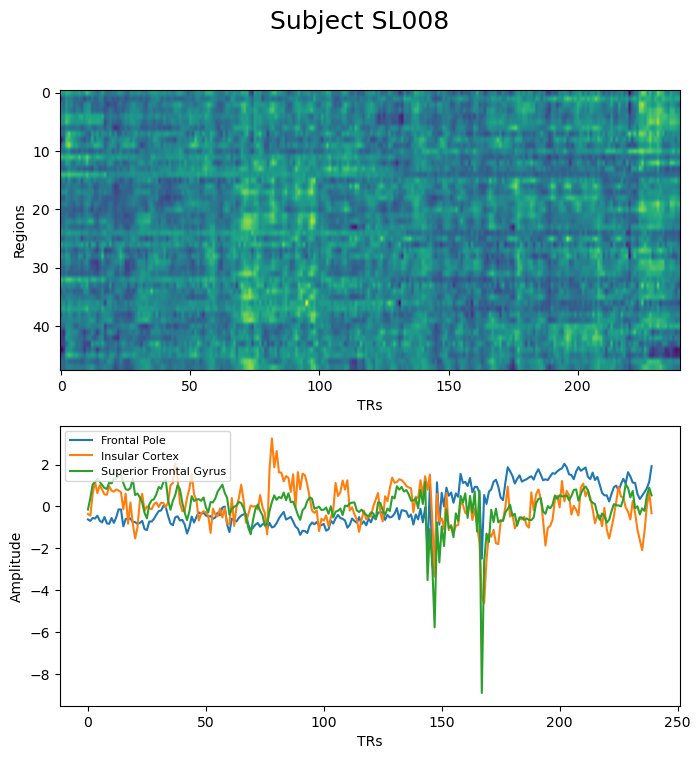

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].imshow(roidata_masked["R"][3].T, aspect='auto')
ax[0].set_xlabel("TRs")
ax[0].set_ylabel("Regions")

[ax[1].plot(roidata_masked["R"][2][:, idx], label=labels[idx+1]) for idx in range(3)] # labels come from `nilearn_mask_single_data()`
ax[1].legend(loc=2, prop={'size': 8})
ax[1].set_xlabel("TRs")
ax[1].set_ylabel("Amplitude")

fig.suptitle(f'Subject {pps["R"][3]}', fontsize=18)

Looking at the ROI labels.

>Note `background` is not an ROI

In [1]:
labels

NameError: name 'labels' is not defined

Grab some rois!

In [18]:
rois2extract = ['Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Frontal Medial Cortex']

# where in labels are these ROIs?
roi_idx = [labels.index(i) for i in rois2extract]

# labels are shifted +1 so adjust for actual brain data
roi_idx_adjust = [i - 1 for i in roi_idx]
print(roi_idx_adjust)


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24]


In [38]:
X = np.mean(roidata_masked["S"], axis=0)

In [57]:
t = np.array([1, 2, 3, 4, 5, 6, 7, 78, 8], dtype=int)
id = [2, 3]
t[id]
tt = roidata_masked["S"][id]


(0, 10, 240, 48)

# Formal model fitting procedure

As mentioned earlier, we are using `brainiak` to conduct our event segmentation analysis. This requires a separate `conda` environment

In [58]:
from sklearn.model_selection import LeaveOneOut, KFold
from brainiak.eventseg.event import EventSegment
import numpy as np

In [59]:
tidx = [1,2,3,4,7,8]
tdata = roidata_masked["S"][tidx]
es= EventSegment()

In [61]:
es.fit(tdata.T)

ValueError: Found array with dim 3. Estimator expected <= 2.

## Set up some variables

In [21]:
n_subs = len(data) # total subjects
n_struct = len(roidata["S"]) # subjects in the structured group
n_rand = len(roidata["R"]) # subjects in the random group
n_splits_inner = 4
subj_id_struct = np.array([i for i in range(n_struct)])
subj_id_rand = np.array([i for i in range(n_rand)])
k_vals = np.arange(2, 10) # testing all values of k

## Begin nested cross validation for **structured**.

In [20]:
# outer loop loo class
loo_outer = LeaveOneOut()
loo_outer.get_n_splits(subj_id_struct)

# condition variable
cond = "S"

10

In [ ]:
for subj_id_train_outer, subj_id_test_outer in loo_outer.split(subj_id_struct):

    # 

    

In [40]:
for subj_id_train_outer, subj_id_test_outer in loo_outer.split(subj_id_struct):

    print("Outer:\tTrain:", subj_id_train_outer, "Test:", subj_id_test_outer)

    # loop over outer train
    for sub in subj_id_train_outer:

        # instantiate
        es = EventSegment()

        # aggregate training set
        data_outer = roidata_masked[cond][subj_id_train_outer]

        # get training set
        data_train = data

        # fit
        es.fit(roidata[cond][subj_id_train_outer][:, roi_idx_adjust].T)

        # set up inner loop loo structure
        subj_id_struct_inner = subj_id_struct[subj_id_train_outer]
        kf = KFold(n_splits=n_splits_inner)
        kf.get_n_splits(subj_id_train_outer)

        for subj_id_train_inner, subj_id_test_inner in kf.split(subj_id_struct_inner):
            # inplace update the ids w.r.t. to the inner training set
            subj_id_train_inner = subj_id_struct_inner[subj_id_train_inner]
            subj_id_test_inner = subj_id_struct_inner[subj_id_test_inner]
            print("-Train:", subj_id_train_inner, "Test:", subj_id_test_inner, ', now try different k...')
        print()




Outer:	Train: [1 2 3 4 5 6 7 8 9] Test: [0]
-Train: [4 5 6 7 8 9] Test: [1 2 3] , now try different k...
-Train: [1 2 3 6 7 8 9] Test: [4 5] , now try different k...
-Train: [1 2 3 4 5 8 9] Test: [6 7] , now try different k...
-Train: [1 2 3 4 5 6 7] Test: [8 9] , now try different k...

Outer:	Train: [0 2 3 4 5 6 7 8 9] Test: [1]
-Train: [4 5 6 7 8 9] Test: [0 2 3] , now try different k...
-Train: [0 2 3 6 7 8 9] Test: [4 5] , now try different k...
-Train: [0 2 3 4 5 8 9] Test: [6 7] , now try different k...
-Train: [0 2 3 4 5 6 7] Test: [8 9] , now try different k...

Outer:	Train: [0 1 3 4 5 6 7 8 9] Test: [2]
-Train: [4 5 6 7 8 9] Test: [0 1 3] , now try different k...
-Train: [0 1 3 6 7 8 9] Test: [4 5] , now try different k...
-Train: [0 1 3 4 5 8 9] Test: [6 7] , now try different k...
-Train: [0 1 3 4 5 6 7] Test: [8 9] , now try different k...

Outer:	Train: [0 1 2 4 5 6 7 8 9] Test: [3]
-Train: [4 5 6 7 8 9] Test: [0 1 2] , now try different k...
-Train: [0 1 2 6 7 8 9] Test

In [17]:
# set up inner loop loo structure
subj_id_all_inner = subj_id_struct[subj_id_train_outer]
kf = KFold(n_splits=n_splits_inner)
kf.get_n_splits(subj_id_train_outer)
for subj_id_train_inner, subj_id_test_inner in kf.split(subj_id_all_inner):
    # inplace update the ids w.r.t. to the inner training set
    subj_id_train_inner = subj_id_all_inner[subj_id_train_inner]
    subj_id_test_inner = subj_id_all_inner[subj_id_test_inner]
    print("-Train:", subj_id_train_inner, "Test:", subj_id_test_inner, ', now try different k...')
print()

-Train: [ 5  6  7  8  9 10 11 12 13 14 15 16 17] Test: [0 1 2 3 4] , now try different k...
-Train: [ 0  1  2  3  4 10 11 12 13 14 15 16 17] Test: [5 6 7 8 9] , now try different k...
-Train: [ 0  1  2  3  4  5  6  7  8  9 14 15 16 17] Test: [10 11 12 13] , now try different k...
-Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] Test: [14 15 16 17] , now try different k...



In [90]:
k_vals = np.arange(2, 10)
b = {}
for k in k_vals:
    logL = []

    # instantiate
    es = EventSegment(k)

    # fit
    es.fit(roidata["S"][2][:, roi_idx_adjust])

    # append
    logL.append(es.ll_)

    b[str(k)] = np.max(es.ll_)


In [91]:
b

{'2': -366.97882688762223,
 '3': -359.9384237513052,
 '4': -355.26108001536016,
 '5': -348.64849814344933,
 '6': -347.35747232550835,
 '7': -342.36048500365274,
 '8': -344.4158087179627,
 '9': -340.9045176362823}

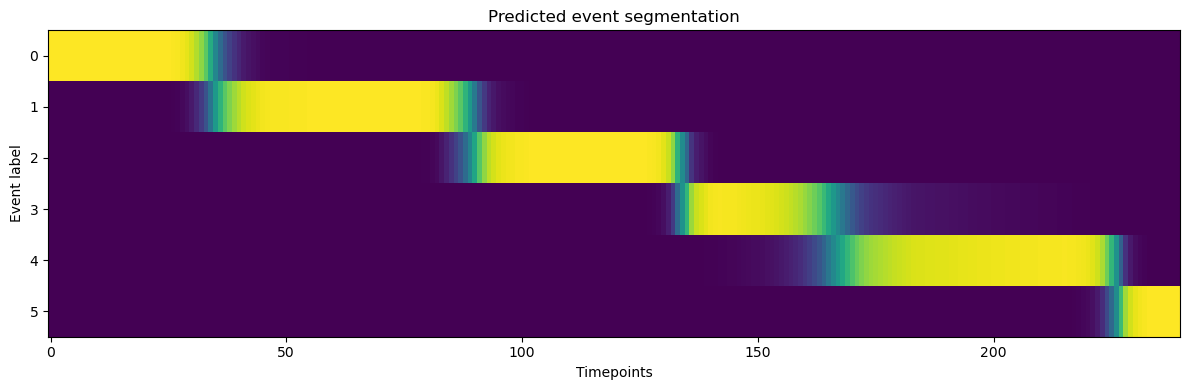

In [89]:
# plot 
f, ax = plt.subplots(1,1, figsize=(12,4))

pred_seg = es.segments_[0]
ax.imshow(pred_seg.T, aspect='auto', cmap='viridis')
ax.set_xlabel('Timepoints')
ax.set_ylabel('Event label')
ax.set_title('Predicted event segmentation')

f.tight_layout()

In [63]:
x = [-1, -2, -3, -4]
np.min(x)
np.max(x)

-1